# Influence of Load Introduction Method on Wingbox Optimization with Nonlinear Structural Stability Constraints

This notebook shows how to produce the figures published in the paper titled _Influence of Load Introduction Method on Wingbox Optimization with Nonlinear Structural Stability Constraints_, presented at the the International Forum on Aeroelasticity and Structudal Dynamics (IFASD) in June 2024 and authored by Francesco M. A. Mitrotta, Alberto Pirrera, Terence Macquart, Jonathan E. Cooper, Alex Pereira do Prado and Pedro Higino Cabral.

* [Influence of load introduction method](#load-introduction)
    * [Nonlinear structural stability response of initial structure](#initial)
    * [Optimization with distributed non-follower forces](#distributed)
    * [Optimization with non-follower forces applied to load reference axis](#reference-axis)
    * [Optimization with follower forces](#follower)   
    * [Comparative discussion](#comparative)
* [Appendix](#appendix)

In [1]:
import os  # package for interacting with the operating system
import matplotlib.pyplot as plt  # package for creating figures and plots
from matplotlib.lines import Line2D  # class holding the list of markers
import tol_colors as tc  # package for colorblind-friendly colors
import numpy as np  # package for scientific computing

# Define name of directory where to find the analyses
analysis_directory_name = "21_Optimization_of_the_CRM-like_Box_Beam_with_Distributed_Load"
ANALYSIS_DIRECTORY_PATH = os.path.join(os.getcwd(), "analyses", analysis_directory_name)

# Define name of directory where to save figures
figures_directory_name = "IFASD_2024"
FIGURES_DIRECTORY_PATH = os.path.join(os.getcwd(), "analyses", figures_directory_name)

# Define default figure parameters
TEXTWIDTH_INCHES = 6.298242  # paper textwidth in inches
FIG_WIDTH_INCHES = TEXTWIDTH_INCHES*.5
FIG_HEIGHT_INCHES = FIG_WIDTH_INCHES*(4.8/6.4)  # default figure height in inches
DEFAULT_FONT_SIZE = 8  # default font size of figures
DEFAULT_MARKER_SIZE = 3  # default marker size of lines
plt.rcParams.update({
    'figure.dpi': 120,  # default figure dpi
    'text.usetex': True,  # use LaTeX to render text
    'font.family': 'serif',  # use serif font family
    'font.serif': 'Times New Roman',  # use Times New Roman for serif font
    'font.size': DEFAULT_FONT_SIZE,  # default font size of figures
    'mathtext.fontset': 'custom',  # use custom font settings for math
    'mathtext.rm': 'Times New Roman',  # use Times New Roman for roman math text
    'mathtext.it': 'Times New Roman:italic',  # use Times New Roman italic for italic math text
    'mathtext.bf': 'Times New Roman:bold',  # use Times New Roman bold for bold math text
    'lines.markersize': DEFAULT_MARKER_SIZE  # set default marker size of lines
})

# Define default colors and markers
MARKERS = list(Line2D.markers.keys())[2:]  # list of marker characters
plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))  # set default color cycle to TOL bright
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']  # retrieve list with succession of standard matplotlib colors
UNSTABLE_COLOR = COLORS[1]  # red
GLASS_CEILING_COLOR = COLORS[2]  # green
del COLORS[1:3]  # delete green and red from list of colors

# Define default print options for numpy
np.set_printoptions(precision=1, suppress=True)

# Define constant variables for the analyses
L = 29.38e3  # [mm] box beam length
W = 3.41e3   # [mm] box beam width
H = .77e3    # [mm] box beam height
FIRST_SUBCASE_ID = 1  # id of first subcase
SECOND_SUBCASE_ID = 2  # id of second subcase
Z_COMPONENT_INDEX = 2  # index of z-component in vector of displacements

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 80  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .62))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-.07, .18))  # move colorbar upwards

## Influence of load introduction method <a name="load-introduction"></a>

***

### Nonlinear structural stability response of initial structure <a name="initial"></a>

Linear buckling load and mode for model under distributed non-follower forces.

Linear buckling load: 30438 N
Buckling mode:


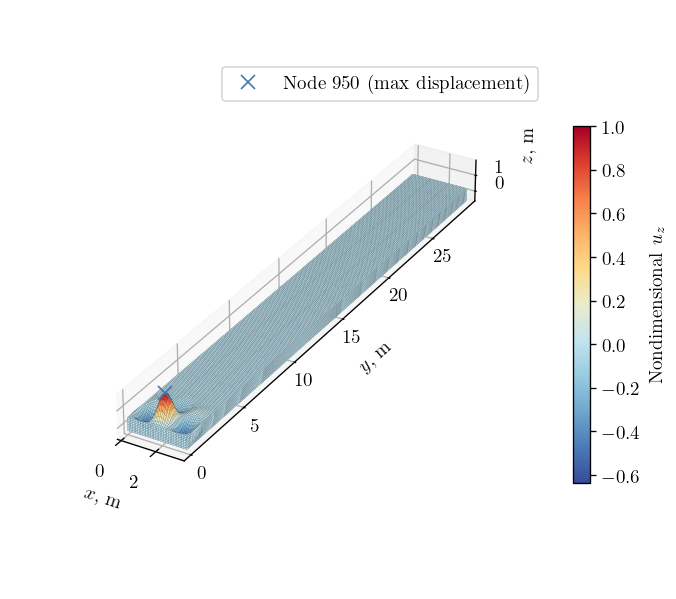

In [2]:
from pyNastran.op2.op2 import read_op2
from resources import plot_utils

# Read op2 file
input_name = "sol_105_33120_elements"
op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2')
sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)

# Find buckling load and plot buckling mode
linear_buckling_load = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigr
print(f"Linear buckling load: {linear_buckling_load:.0f} N")
print("Buckling mode:")
amplification_factor = 1.5  # amplification factor of displacements
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/0.7),
                     'lines.markersize': 8})  # increase default font size
fig, ax, cbar = plot_utils.plot_buckling_mode(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz', colormap='sunset',
    length_unit='m', displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3)

# Find node where max displacement occurs
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[
    0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[
    max_displacement_index, 0]
local_displacement_node_ids = [max_displacement_node_id]  # initialize list of node ids where to plot local displacements

# Plot node where maximum displacement occurs
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz*1e-3 + sol_105_op2.eigenvectors[
    SECOND_SUBCASE_ID].data[0, max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x',
        label=f"Node {max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend(bbox_to_anchor=(.93, .92))

# Adjust plot, show it and save figure
adjust_3d_plot(ax, cbar)
plt.show()
BBOX_COLORBAR = fig.bbox_inches.from_bounds(.8, .5, 5.2, 3.9)  # create bounding box for figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "InitialBucklingMode.png"), format='png', bbox_inches=BBOX_COLORBAR, pad_inches=0, dpi=500)

# Reset default sizes
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE,
                     'lines.markersize': DEFAULT_MARKER_SIZE})

Compare linear buckling loads obtained with the different load introduciton methods.

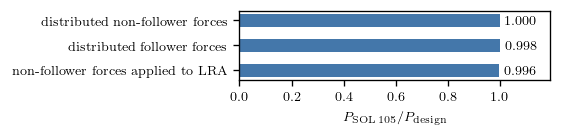

Percentage differences of linear buckling loads w.r.t. distributed non-follower result:
- distributed follower forces --> -0.2%
- non-follower forces applied to LRA --> -0.4%



In [3]:
# Initialize dictionary with names of input files
sol_105_input_name_dict = {"distributed non-follower forces": "sol_105_non_follower_linear_opt_start",
                           "distributed follower forces": "sol_105_follower_linear_opt_start",
                           "non-follower forces applied to LRA": "sol_105_lra_linear_opt_start"}

# Read linear buckling load for each analysis
linear_buckling_loads = []
for input_name in sol_105_input_name_dict.values():
     op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2')
     sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
     linear_buckling_loads.append(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0])

# Plot bar chart with linear buckling loads
fig, ax = plt.subplots(figsize=(FIG_WIDTH_INCHES*1.5, FIG_HEIGHT_INCHES/2))
y_pos = np.arange(len(sol_105_input_name_dict.keys()))  # position of bars
p = ax.barh(y_pos, linear_buckling_loads, height=0.5)  # plot bars
ax.bar_label(p, padding=3, fmt="{:,.3f}")  # add labels to bars
ax.set_yticks(y_pos, labels=tuple(sol_105_input_name_dict.keys()))  # set labels of y-axis
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("$P_\mathrm{SOL\,105}/P_\mathrm{design}$")  # set label of x-axis
ax.set_xlim(right=1.19)  # set limits of x-axis

# Save figure
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "LinearBucklingBarChart.svg"), format='svg', bbox_inches='tight', pad_inches=0)

# Calculate percentage differences w.r.t. distributed non-follower forces
print(f"""Percentage differences of linear buckling loads w.r.t. distributed non-follower result:
- distributed follower forces --> {100*(linear_buckling_loads[1]-linear_buckling_loads[0])/linear_buckling_loads[0]:.1f}%
- non-follower forces applied to LRA --> {100*(linear_buckling_loads[2]-linear_buckling_loads[0])/linear_buckling_loads[0]:.1f}%
""")

Compare root bending moment obtained with the different load introduciton methods.

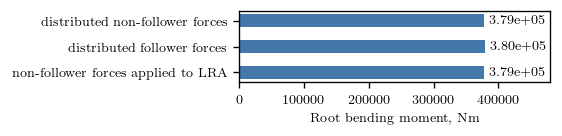

Percentage differences of root bending moments w.r.t. distributed non-follower result:
- distributed follower forces --> 0.23%
- non-follower forces applied to LRA --> 0.00%



In [4]:
def read_rbm_from_f06(f06_path):
    with open(f06_path, 'r') as file:
        # Flag to indicate if we are in the relevant section
        in_relevant_section = False
        # Loop through the lines of the file
        for line in file:
            # Check if the line indicates the start of the relevant section
            if 'SUBCASE/' in line:
                in_relevant_section = True
            # Once we are in the relevant section, look for the row starting with FZ
            if in_relevant_section and line.startswith('               FZ'):
                # Split the line into parts
                parts = line.split()
                # The R1 value is the 4th number from the end
                r1_value = parts[-3]
                return float(r1_value)
            # If we encounter the word 'TOTALS', it means we are past the section of interest
            if 'TOTALS' in line:
                in_relevant_section = False
    # Return None if the value is not found
    return None

# Read root bending moment for each analysis
root_bending_moments = []
for input_name in sol_105_input_name_dict.values():
    f06_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')
    root_bending_moments.append(read_rbm_from_f06(f06_filepath))

# Plot bar chart with linear buckling loads
fig, ax = plt.subplots(figsize=(FIG_WIDTH_INCHES*1.5, FIG_HEIGHT_INCHES/2))
y_pos = np.arange(len(sol_105_input_name_dict.keys()))  # position of bars
p = ax.barh(y_pos, np.array(root_bending_moments)/1e3, height=0.5)  # plot bars
ax.bar_label(p, padding=3, fmt="{:,.2e}")  # add labels to bars
ax.set_yticks(y_pos, labels=tuple(sol_105_input_name_dict.keys()))  # set labels of y-axis
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Root bending moment, Nm")  # set label of x-axis
ax.set_xlim(right=4.8e5)  # set limits of x-axis

# Save figure
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "RootBendingMomentBarChart.svg"), format='svg', bbox_inches='tight', pad_inches=0)

# Calculate percentage differences w.r.t. distributed non-follower forces
print(f"""Percentage differences of root bending moments w.r.t. distributed non-follower result:
- distributed follower forces --> {100*(root_bending_moments[1]-root_bending_moments[0])/root_bending_moments[0]:.2f}%
- non-follower forces applied to LRA --> {100*(root_bending_moments[2]-root_bending_moments[0])/root_bending_moments[0]:.2f}%
""")

Comparison of nonlinear structural stability response of initial structure.

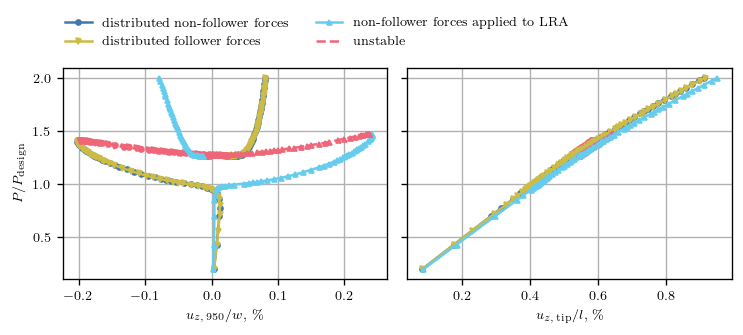

In [5]:
from resources import pynastran_utils

# Design load is equal to linear buckling load of initial structure under distributed non-follower forces
design_load = linear_buckling_load

# Find id of tip node
tip_node_xyz = np.array([W/2, L, 0])  # tip node is taken at the center of the tip rib
nodes_xyz_array = np.array([sol_105_op2.nodes[i].xyz for i in sol_105_op2.nodes])
tip_node_id = np.argmin(np.linalg.norm(nodes_xyz_array - tip_node_xyz, axis=1)) + 1

# Initialize dictionary with names of input files
input_name_dict = {"distributed non-follower forces": "sol_106_33120_elements",
                   "distributed follower forces": "sol_106_follower_linear_opt_start",
                   "non-follower forces applied to LRA": "sol_106_lra_linear_opt_start"}

def plot_load_displacement_diagram(input_name_dict, max_nondimensional_load=1):
    # Create one figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(TEXTWIDTH_INCHES, FIG_HEIGHT_INCHES))
    stable_lines = []

    # Read eigenvalues, load and displacement histories and plot load-displacement diagrams
    eigenvalues_dict = {}
    sol_106_op2_dict = {}
    nondimensional_loads_dict = {}
    for count, (key, input_name) in enumerate(input_name_dict.items()):

        # Read eigenvalues
        f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
        eigenvalues_dict[key] =pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

        # Read load and displacement histories
        sol_106_op2_dict[key] = read_op2(os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2'), load_geometry=True, debug=None)
        _, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(
            op2=sol_106_op2_dict[key], node_ids=[max_displacement_node_id, tip_node_id])
        nondimensional_loads_dict[key] = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/design_load
        
        # Plot applied load vs root displacement
        last_plot_index = np.argmin(np.abs(nondimensional_loads_dict[key] - max_nondimensional_load)) + 1  # limit plot to applied loads less than or equal to design load
        if last_plot_index > eigenvalues_dict[key].shape[1]:
            last_plot_index -= 1
        plot_utils.plot_2d_load_displacements_stability(
            axes[0],
            displacements[max_displacement_node_id][FIRST_SUBCASE_ID][:last_plot_index, Z_COMPONENT_INDEX]/W*100,
            nondimensional_loads_dict[key][:last_plot_index],
            eigenvalues_dict[key][:, :last_plot_index],
            MARKERS[count], COLORS[count])
        stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[count], color=COLORS[count], label=key))

        # Plot applied load vs tip displacement
        plot_utils.plot_2d_load_displacements_stability(
            axes[1],
            displacements[tip_node_id][FIRST_SUBCASE_ID][:last_plot_index, Z_COMPONENT_INDEX]/L*100,
            nondimensional_loads_dict[key][:last_plot_index],
            eigenvalues_dict[key][:, :last_plot_index],
            MARKERS[count], COLORS[count])
        
    # Return 
    return fig, axes, stable_lines, eigenvalues_dict, sol_106_op2_dict, nondimensional_loads_dict

# Plot load-displacement diagrams
fig, axes, stable_lines, eigenvalues_dict, sol_106_op2_dict, nondimensional_loads_dict = plot_load_displacement_diagram(
    input_name_dict, max_nondimensional_load=2)

# Create proxy artists for unstable segments
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")

# Set plot appearance for the first subplot
axes[0].set_xlabel(f"$u_{{z,\,{max_displacement_node_id:d}}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[1].grid(visible=True)

# Save figure
plt.tight_layout()  # Ensures proper spacing between subplots
axes[0].legend(handles=stable_lines + [unstable_line], loc="upper left",
               ncols=2, bbox_to_anchor=(-.03, 1.3), frameon=False)  # add legend after tight_layout
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "InitialLoadDisplacementDiagram.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Compare applied load at first limit point.

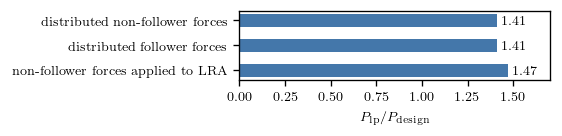

Percentage differences of limit point loads w.r.t. distributed non-follower result:
- distributed follower forces --> -0.1%
- non-follower forces applied to LRA --> 4.3%



In [6]:
# Find limit point load for each analysis
first_negative_eigenvalue_index_dict = {}
limit_point_loads = []
for key in sol_105_input_name_dict:
    first_negative_eigenvalue_index_dict[key] = np.where(eigenvalues_dict[key][0] < 0)[0][0]  # find index of first negative eigenvalue
    limit_point_loads.append(np.mean(
        nondimensional_loads_dict[key][first_negative_eigenvalue_index_dict[key] - 1:first_negative_eigenvalue_index_dict[key] + 1]))  # calculate nondimensional applied load at limit point as the mean between the last stable and first unstable load

# Plot bar chart with limit point loads
fig, ax = plt.subplots(figsize=(FIG_WIDTH_INCHES*1.5, FIG_HEIGHT_INCHES/2))
y_pos = np.arange(len(sol_105_input_name_dict.keys()))  # position of bars
p = ax.barh(y_pos, limit_point_loads, height=0.5)  # plot bars
ax.bar_label(p, padding=3, fmt="{:,.2f}")  # add labels to bars
ax.set_yticks(y_pos, labels=tuple(sol_105_input_name_dict.keys()))  # set labels of y-axis
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("$P_\mathrm{lp}/P_\mathrm{design}$")  # set label of x-axis
ax.set_xlim(right=1.7)  # set limits of x-axis

# Save figure
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "LimitPointLoadBarChart.svg"), format='svg', bbox_inches='tight', pad_inches=0)

# Calculate percentage differences w.r.t. distributed non-follower forces
print(f"""Percentage differences of limit point loads w.r.t. distributed non-follower result:
- distributed follower forces --> {100*(limit_point_loads[1]-limit_point_loads[0])/limit_point_loads[0]:.1f}%
- non-follower forces applied to LRA --> {100*(limit_point_loads[2]-limit_point_loads[0])/limit_point_loads[0]:.1f}%
""")

Compare deformation under distributed non-follower forces vs non-follower forces applied to LRA under limit point load.

Deformation under distributed non-follower forces


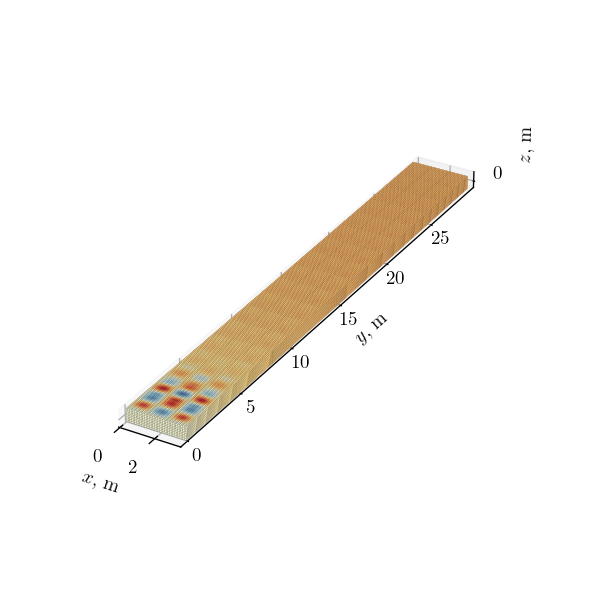

Deformation under non-follower forces applied to LRA


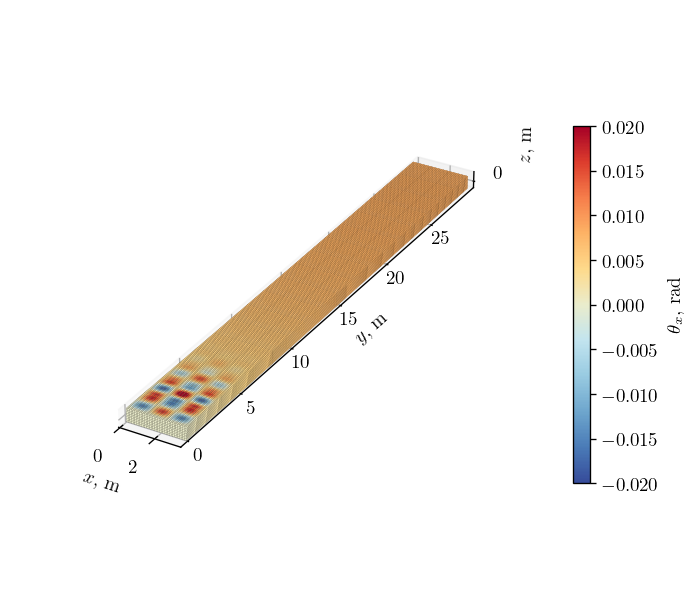

In [7]:
# Plot deformation under distributed non-follower forces
key = "distributed non-follower forces"
print(f"Deformation under {key}")
clim = [-.02, .02]  # color limits for deformation plot
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/.7)})
fig, ax, cbar = plot_utils.plot_static_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=first_negative_eigenvalue_index_dict[key], clim=clim,
    displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3)
adjust_3d_plot(ax, cbar)
ax.set_zticks([0])
cbar.remove()
plt.show()
BBOX_NO_COLORBAR = fig.bbox_inches.from_bounds(.8, .5, 4., 3.9)  # create bounding box for figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"deformation_{key.replace(' ', '_')}.png"),
            format='png', bbox_inches=BBOX_NO_COLORBAR, pad_inches=0, dpi=500)

# Plot deformation under non-follower forces applied to LRA
key = "non-follower forces applied to LRA"
print(f"Deformation under {key}")
fig, ax, cbar = plot_utils.plot_static_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=first_negative_eigenvalue_index_dict[key], clim=clim,
    displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3)
adjust_3d_plot(ax, cbar)
ax.set_zticks([0])
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"deformation_{key.replace(' ', '_')}.png"),
            format='png', bbox_inches=BBOX_COLORBAR, pad_inches=0, dpi=500)

# Restore default font size
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})

Compare deformation before and after snap-through for the case with distributed non-follower forces.

Deformation before snap:


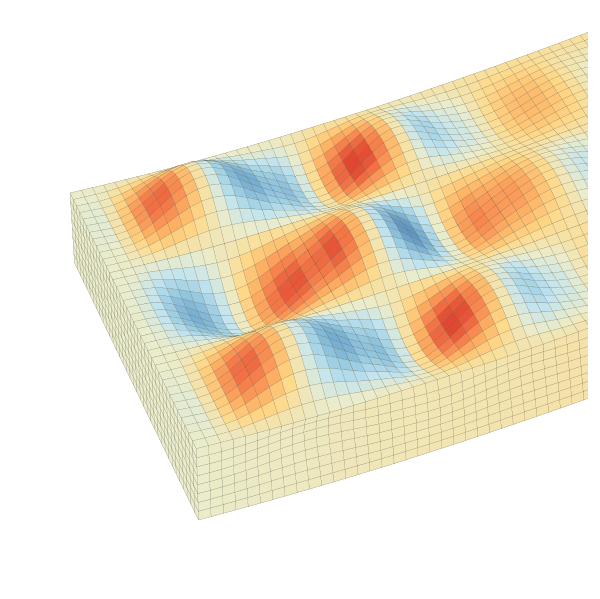

Deformation just after snap


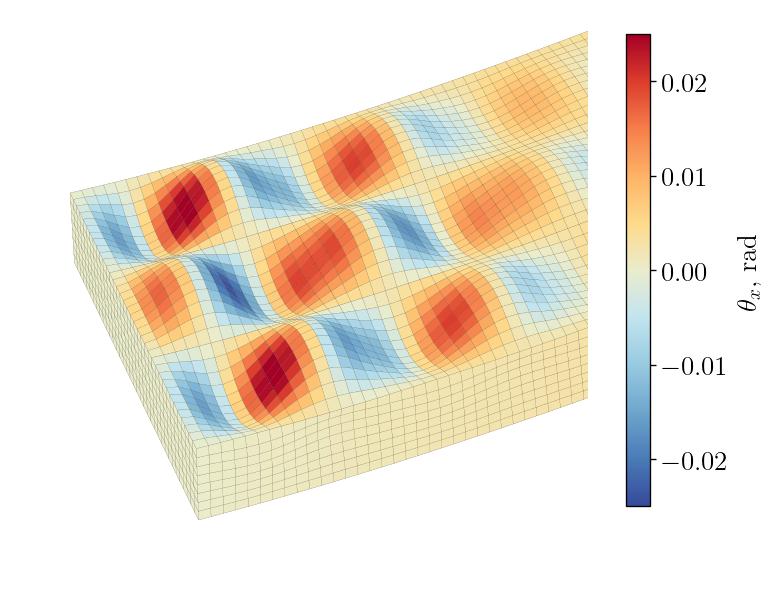

In [8]:
# Increase font size because figures are rendered side by side in the paper
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/.49)})

# Plot deformation just before limit point
key = "distributed non-follower forces"
print("Deformation before snap:")
amplification_factor = 50  # amplification factor for displacements
clim = [-.025, .025]  # color limits for deformation plot
fig, ax, cbar = plot_utils.plot_static_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=first_negative_eigenvalue_index_dict[key], displacement_component='rx',
    colormap='sunset', length_unit='m', unit_scale_factor=1e-3, clim=clim, displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax)
cbar.remove()
ax.set_xlim(0, W*1e-3)
ax.set_ylim(0, 4*H*1e-3)
ax.set_zlim(-H/2*1e-3, H*1e-3)
ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f"get_{a}lim")() for a in 'xyz')])
plt.axis('off')
ax.view_init(40, -20)
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "BeforeSnap.svg"), format='svg', bbox_inches='tight', pad_inches=0)

# Plot deformation just after snap
skip = 10  # number of increments to skip for selection of applied load after snap
subsequent_values = nondimensional_loads_dict[key][first_negative_eigenvalue_index_dict[key] + skip:]  # consider only applied loads after snap
closest_index_in_subsequent = np.argmin(np.abs(limit_point_loads[0] - subsequent_values))  # find index of closest value to applied load at first limit point
closest_index = first_negative_eigenvalue_index_dict[key] + skip + closest_index_in_subsequent  # sum found index to index of first negative eigenvalue
print("Deformation just after snap")
fig, ax, cbar = plot_utils.plot_static_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=closest_index + 1, displacement_component='rx', colormap='sunset', length_unit='m',
    unit_scale_factor=1e-3, displacement_amplification_factor=amplification_factor, clim=clim)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax)
cbar.ax.set_position(cbar.ax.get_position().shrunk(1.0, .82))  # decrease colorbar size
cbar.ax.set_position(cbar.ax.get_position().translated(0, .14))  # move colorbar upwards
ax.set_xlim(0, W*1e-3)
ax.set_ylim(0, 4*H*1e-3)
ax.set_zlim(-H/2*1e-3, H*1e-3)
ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f"get_{a}lim")() for a in 'xyz')])
plt.axis('off')
ax.view_init(40, -20)
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "AfterSnap.svg"), format='svg', bbox_inches='tight', pad_inches=0)

# Restore default font size
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})

### Optimization with distributed non-follower forces <a name="distributed"></a>

Plot history of optimization with linear constraints.

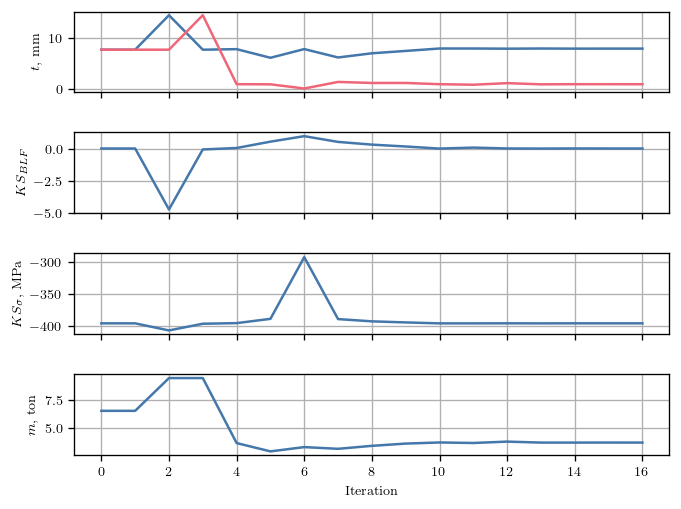

Final values:
- interp.t_cp: [7.9 1. ]
- nastran_solver.ks_buckling: [0.]
- nastran_solver.ks_stress: [-395.4]
- nastran_solver.mass: [3.8]
Mass reduction: -42.2%


In [9]:
from resources import optimization_utils

recorder_filename = "sol_105_non_follower_linear_opt.sql"
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, recorder_filename)
fig, sol_105_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
mass_reduction = 100*(sol_105_opt_histories['nastran_solver.mass'][-1, 0] - sol_105_opt_histories['nastran_solver.mass'][0, 0])/\
    sol_105_opt_histories['nastran_solver.mass'][0, 0]
print(f"Mass reduction: {mass_reduction:.1f}%")
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "NonFollowerLinearOptHistory.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Plot history of optimization with nonlinear constraints.

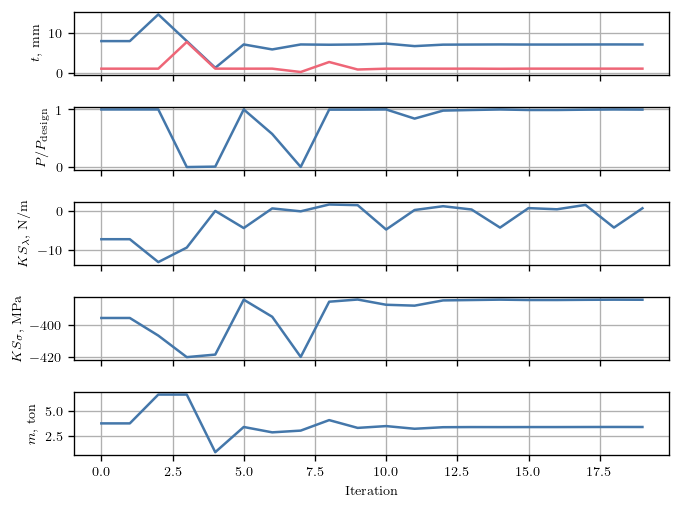

Final values:
- interp.t_cp: [7.1 1. ]
- nastran_solver.applied_load: [1.]
- nastran_solver.ks_stability: [0.8]
- nastran_solver.ks_stress: [-384.]
- nastran_solver.mass: [3.4]


In [10]:
recorder_filename = "sol_106_non_follower_nonlinear_opt.sql"
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, recorder_filename)
fig, sol_106_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "NonFollowerNonlinearOptHistory.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Find final mass at last feasible iteration.

In [11]:
feasible_design_index = np.where(sol_106_opt_histories['nastran_solver.ks_stability'][:, 0] <= 0)[0][-1]
initial_mass = sol_105_opt_histories["nastran_solver.mass"][0, 0]*1e3
final_masses = {"linear constraint": (sol_105_opt_histories["nastran_solver.mass"][-1, 0]*1e3,),
                "nonlinear constraint": (sol_106_opt_histories["nastran_solver.mass"][feasible_design_index, 0]*1e3,)}  # convert mass to kg
mass_reduction = 100*(sol_106_opt_histories['nastran_solver.mass'][feasible_design_index, 0] - sol_106_opt_histories['nastran_solver.mass'][0, 0])/\
    sol_106_opt_histories['nastran_solver.mass'][0, 0]
print(f"Mass reduction: {mass_reduction:.1f}%")

Mass reduction: -9.3%


Plot bar chat of final thicknesses.

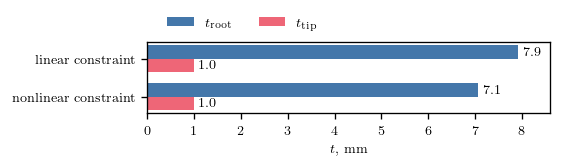

In [12]:
# Define function to plot bar chart of final thicknesses
def plot_thickness_bar_chart(sol_105_opt_histories, sol_106_opt_histories, figure_filename, iter_index=-1):
    # Set up data for the bar chart
    optimizations = ("linear constraint", "nonlinear constraint")
    final_thicknesses = {
        "$t_\mathrm{root}$": (sol_105_opt_histories["interp.t_cp"][-1, 0], sol_106_opt_histories["interp.t_cp"][iter_index, 0]),
        "$t_\mathrm{tip}$": (sol_105_opt_histories["interp.t_cp"][-1, 1], sol_106_opt_histories["interp.t_cp"][iter_index, 1])
    }

    # Plot bar chart with final thicknesses
    y_pos = np.arange(len(optimizations))  # the label locations
    height = 0.35  # the height of the bars
    multiplier = .5  # multiplier to separate bars
    fig, ax = plt.subplots(figsize=(FIG_WIDTH_INCHES*1.5, FIG_HEIGHT_INCHES/2))  # create figure and axis
    for attribute, values in final_thicknesses.items():  # iterate over attributes and values
        offset = height * multiplier  # offset to separate bars
        rects = ax.barh(y_pos + offset, values, height, label=attribute)  # plot bars
        ax.bar_label(rects, padding=3, fmt="{:,.1f}")  # add labels to bars
        multiplier += 1  # increase multiplier to separate bars

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("$t$, mm")
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_yticks(y_pos + height, optimizations)
    ax.set_xlim(right=8.6)  # set limits of x-axis

    # Save figure
    plt.tight_layout()  # ensures proper spacing between subplots
    ax.legend(bbox_to_anchor=(0.02, 1.), ncols=2, frameon=False)  # add legend after tight layout
    plt.show()
    fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, figure_filename + '.svg'), format='svg', bbox_inches='tight', pad_inches=0)

# Plot bar chart with final thicknesses
figure_name = "Non-followerThicknesses"
plot_thickness_bar_chart(sol_105_opt_histories, sol_106_opt_histories, figure_name)

Comparison of nonlinear structural stability response of initial structure vs linearly optimized structure vs nonlinearly optimized structure.

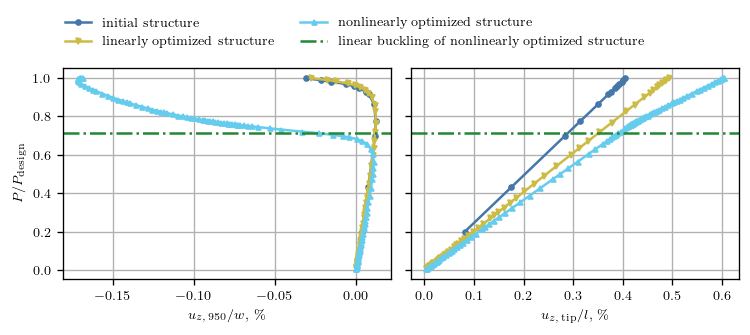

In [13]:
# Initialize dictionary with names of input files
input_name_dict = {"initial structure": "sol_106_33120_elements",
                   "linearly optimized structure": "sol_106_non_follower_linear_opt",
                   "nonlinearly optimized structure": "sol_106_non_follower_nonlinear_opt"}

# Plot load-displacement diagrams
fig, axes, stable_lines, eigenvalues_dict, sol_106_op2_dict, nondimensional_applied_loads_dict = plot_load_displacement_diagram(input_name_dict)

sol_105_input_name = "sol_105_non_follower_nonlinear_opt"
sol_105_op2 = read_op2(os.path.join(ANALYSIS_DIRECTORY_PATH, sol_105_input_name + '.op2'), load_geometry=True, debug=None)
buckling_load_factor = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
axes[0].axhline(y=buckling_load_factor, color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling
axes[1].axhline(y=buckling_load_factor, color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling
glass_ceiling_line = Line2D([0], [0], linestyle='-.', color=GLASS_CEILING_COLOR, label="linear buckling of nonlinearly optimized structure")

# Set plot appearance for the first subplot
axes[0].set_xlabel(f"$u_{{z,\,{max_displacement_node_id:d}}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[1].grid(visible=True)

# Save figure
plt.tight_layout()  # ensures proper spacing between subplots
axes[0].legend(handles=stable_lines + [glass_ceiling_line], loc="upper left",
               ncols=2, bbox_to_anchor=(-.03, 1.3), frameon=False)  # add legend after tight_layout
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "Non-followerLoadDisplacementDiagram.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Compare deformation at design load of linearly vs nonlinearly optimized structure.

Deformation of linearly optimized structure


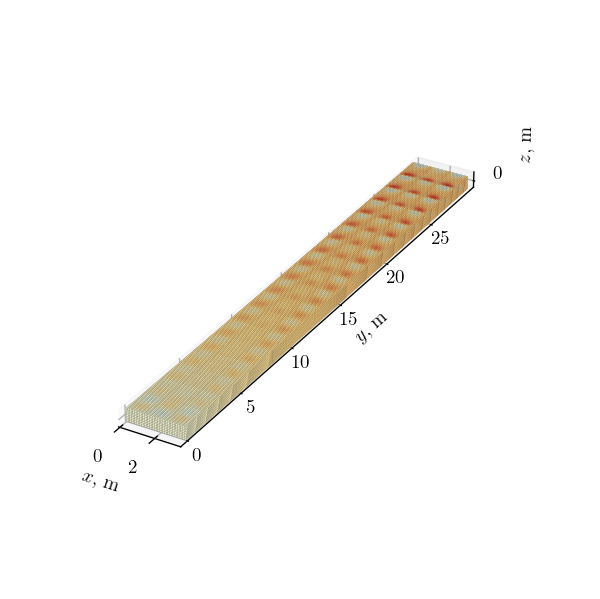

Deformation of nonlinearly optimized structure


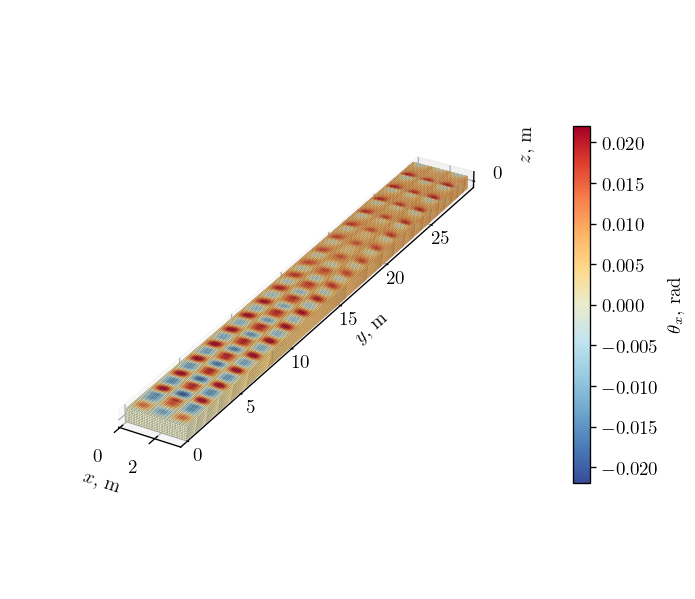

In [14]:
def plot_deformation_comparison(nondimensional_applied_loads_dict, sol_106_op2_dict, label):
    # Plot deformation of linearly optimized structure
    key = "linearly optimized structure"
    print(f"Deformation of {key}")
    clim = [-.022, .022]  # color limits for deformation plot
    increment_number = np.argmin(np.abs(nondimensional_applied_loads_dict[key] - 1)) + 1  # find number of closest converged increment to design load
    plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/.7)})
    fig, ax, cbar = plot_utils.plot_static_deformation(
        op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=increment_number, clim=clim,
        displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3)
    adjust_3d_plot(ax, cbar)
    ax.set_zticks([0])
    cbar.remove()
    plt.show()
    fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"{label}_deformation_{key.replace(' ', '_')}.png"),
                format='png', bbox_inches=BBOX_NO_COLORBAR, pad_inches=0, dpi=500)

    # Plot deformation of nonlinearly optimized structure
    key = "nonlinearly optimized structure"
    print(f"Deformation of {key}")
    fig, ax, cbar = plot_utils.plot_static_deformation(
        op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, clim=clim, displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3)
    adjust_3d_plot(ax, cbar)
    ax.set_zticks([0])
    plt.show()
    fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"{label}_deformation_{key.replace(' ', '_')}.png"),
                format='png', bbox_inches=BBOX_COLORBAR, pad_inches=0, dpi=500)

    # Restore default font size
    plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})

label = "non-follower"
plot_deformation_comparison(nondimensional_applied_loads_dict, sol_106_op2_dict, label)

### Optimization with follower forces <a name="follower"></a>

Plot history of optimization with linear constraints.

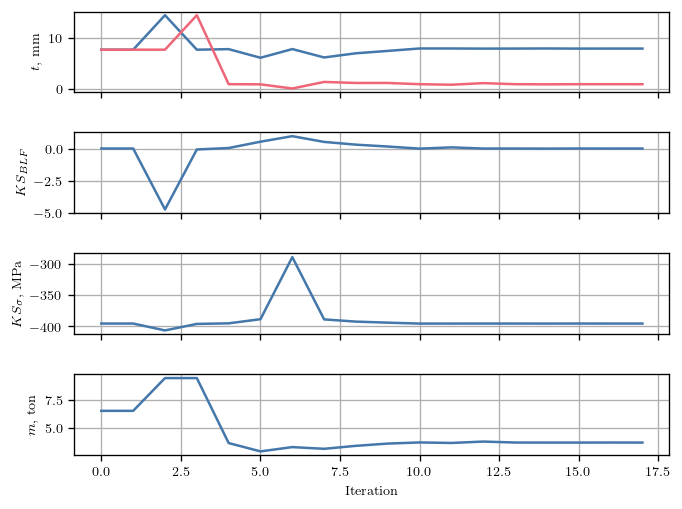

Final values:
- interp.t_cp: [7.9 1. ]
- nastran_solver.ks_buckling: [0.]
- nastran_solver.ks_stress: [-395.4]
- nastran_solver.mass: [3.8]
Mass reduction: -42.1%


In [15]:
recorder_filename = "sol_105_follower_linear_opt.sql"
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, recorder_filename)
fig, sol_105_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
final_masses["linear constraint"] = final_masses["linear constraint"] + (sol_105_opt_histories["nastran_solver.mass"][-1, 0]*1e3,)  # convert mass to kg
mass_reduction = 100*(sol_105_opt_histories['nastran_solver.mass'][-1, 0] - sol_105_opt_histories['nastran_solver.mass'][0, 0])/\
    sol_105_opt_histories['nastran_solver.mass'][0, 0]
print(f"Mass reduction: {mass_reduction:.1f}%")
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "FollowerLinearOptHistory.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Plot history of optimization with nonlinear constraints.

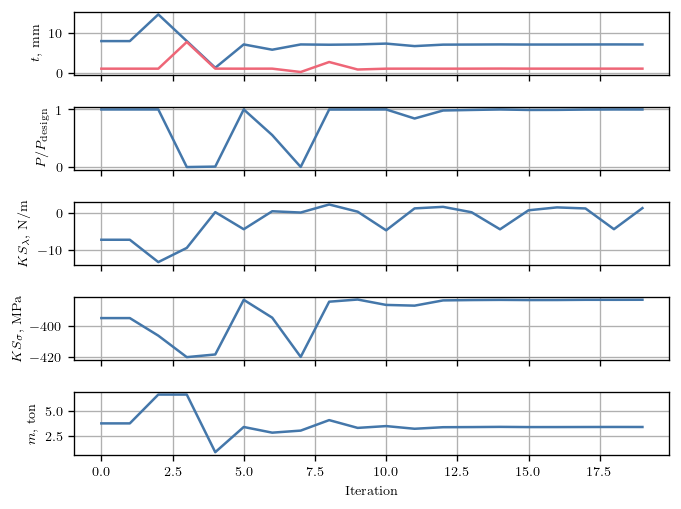

Final values:
- interp.t_cp: [7.1 1. ]
- nastran_solver.applied_load: [1.]
- nastran_solver.ks_stability: [1.2]
- nastran_solver.ks_stress: [-383.8]
- nastran_solver.mass: [3.4]


In [16]:
recorder_filename = "sol_106_follower_nonlinear_opt.sql"
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, recorder_filename)
fig, sol_106_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "FollowerNonlinearOptHistory.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Find final mass at last feasible iteration.

In [17]:
feasible_design_index = np.where(sol_106_opt_histories['nastran_solver.ks_stability'][:, 0] <= 0)[0][-1]
final_masses["nonlinear constraint"] = final_masses["nonlinear constraint"] +\
    (sol_106_opt_histories["nastran_solver.mass"][feasible_design_index, 0]*1e3,)  # convert mass to kg
mass_reduction = 100*(sol_106_opt_histories['nastran_solver.mass'][feasible_design_index, 0] -\
    sol_106_opt_histories['nastran_solver.mass'][0, 0])/sol_106_opt_histories['nastran_solver.mass'][0, 0]
print(f"Mass reduction: {mass_reduction:.1f}%")

Mass reduction: -9.3%


Plot bar chat of final thicknesses.

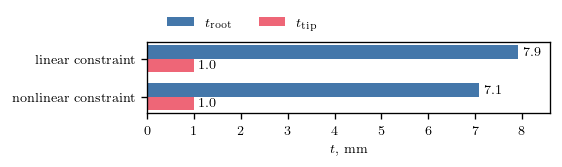

In [18]:
figure_name = "FollowerForcesThicknesses"
plot_thickness_bar_chart(sol_105_opt_histories, sol_106_opt_histories, figure_name)

Comparison of nonlinear structural stability response of initial structure vs linearly optimized structure vs nonlinearly optimized structure.

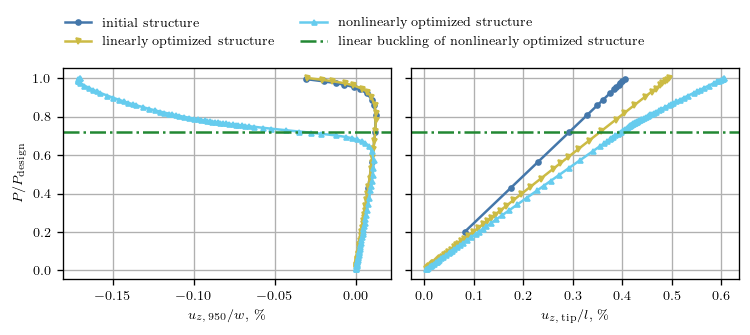

In [19]:
# Initialize dictionary with names of input files
input_name_dict = {"initial structure": "sol_106_follower_linear_opt_start",
                   "linearly optimized structure": "sol_106_follower_linear_opt",
                   "nonlinearly optimized structure": "sol_106_follower_nonlinear_opt"}

# Plot load-displacement diagrams
fig, axes, stable_lines, eigenvalues_dict, sol_106_op2_dict, nondimensional_applied_loads_dict = plot_load_displacement_diagram(input_name_dict)

sol_105_input_name = "sol_105_follower_nonlinear_opt"
sol_105_op2 = read_op2(os.path.join(ANALYSIS_DIRECTORY_PATH, sol_105_input_name + '.op2'), load_geometry=True, debug=None)
buckling_load_factor = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
axes[0].axhline(y=buckling_load_factor, color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling
axes[1].axhline(y=buckling_load_factor, color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling
glass_ceiling_line = Line2D([0], [0], linestyle='-.', color=GLASS_CEILING_COLOR, label="linear buckling of nonlinearly optimized structure")

# Set plot appearance for the first subplot
axes[0].set_xlabel(f"$u_{{z,\,{max_displacement_node_id:d}}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[1].grid(visible=True)

# Save figure
plt.tight_layout()  # ensures proper spacing between subplots
axes[0].legend(handles=stable_lines + [glass_ceiling_line], loc="upper left",
               ncols=2, bbox_to_anchor=(-.03, 1.3), frameon=False)  # add legend after tight_layout
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "FollowerForcesLoadDisplacementDiagram.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Compare deformation at design load of linearly vs nonlinearly optimized structure.

Deformation of linearly optimized structure


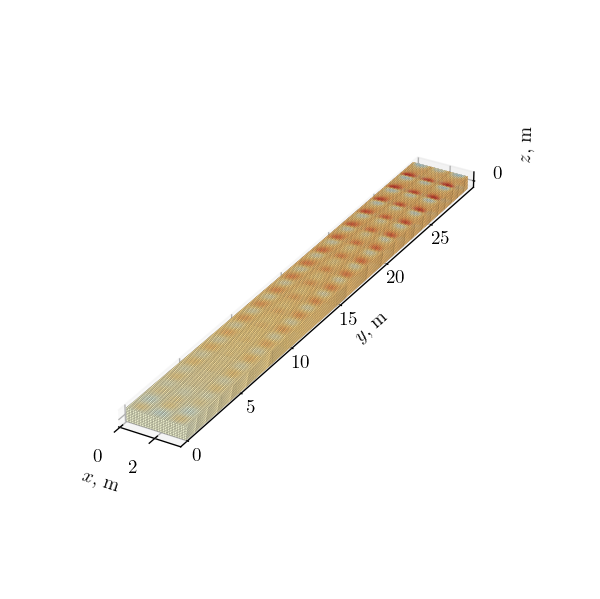

Deformation of nonlinearly optimized structure


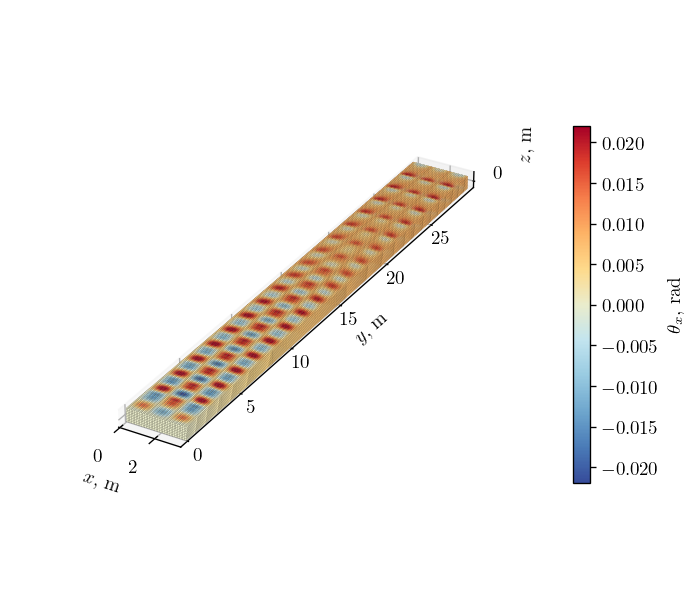

In [20]:
label = "follower"
plot_deformation_comparison(nondimensional_applied_loads_dict, sol_106_op2_dict, label)

### Optimization with non-follower forces applied to load reference axis <a name="reference-axis"></a>

Plot history of optimization with linear constraints.

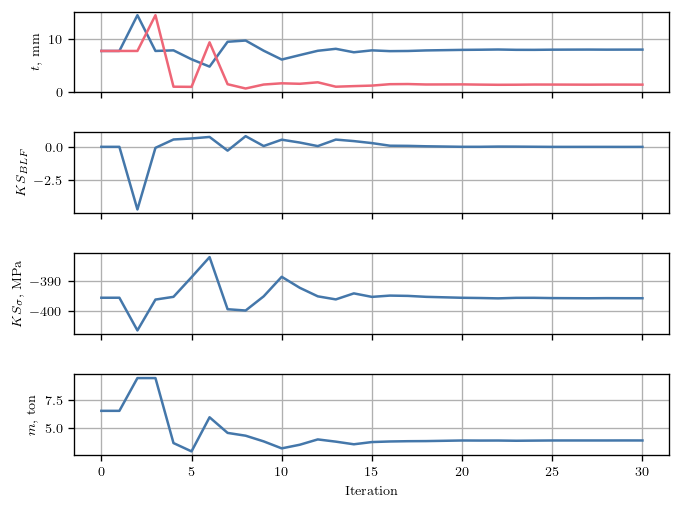

Final values:
- interp.t_cp: [8.  1.4]
- nastran_solver.ks_buckling: [0.]
- nastran_solver.ks_stress: [-395.8]
- nastran_solver.mass: [4.]
Mass reduction: -39.3%


In [21]:
recorder_filename = "sol_105_lra_linear_opt.sql"
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, recorder_filename)
fig, sol_105_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
final_masses["linear constraint"] = final_masses["linear constraint"] + (sol_105_opt_histories["nastran_solver.mass"][-1, 0]*1e3,)  # convert mass to kg
mass_reduction = 100*(sol_105_opt_histories['nastran_solver.mass'][-1, 0] - sol_105_opt_histories['nastran_solver.mass'][0, 0])/\
    sol_105_opt_histories['nastran_solver.mass'][0, 0]
print(f"Mass reduction: {mass_reduction:.1f}%")
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "LraLinearOptHistory.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Plot history of optimization with nonlinear constraints.

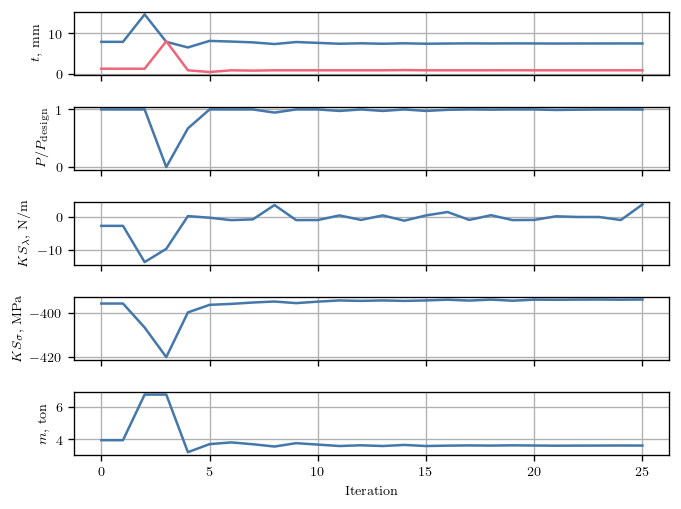

Final values:
- interp.t_cp: [7.6 1. ]
- nastran_solver.applied_load: [1.]
- nastran_solver.ks_stability: [3.8]
- nastran_solver.ks_stress: [-393.9]
- nastran_solver.mass: [3.6]


In [22]:
recorder_filename = "sol_106_lra_nonlinear_opt.sql"
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, recorder_filename)
fig, sol_106_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "LraNonlinearOptHistory.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Find final mass at last feasible iteration.

In [23]:
feasible_design_index = np.where(sol_106_opt_histories['nastran_solver.ks_stability'][:, 0] <= 0)[0][-1]
final_masses["nonlinear constraint"] = final_masses["nonlinear constraint"] +\
    (sol_106_opt_histories["nastran_solver.mass"][feasible_design_index, 0]*1e3,)  # convert mass to kg
mass_reduction = 100*(sol_106_opt_histories['nastran_solver.mass'][feasible_design_index, 0] -\
    sol_106_opt_histories['nastran_solver.mass'][0, 0])/sol_106_opt_histories['nastran_solver.mass'][0, 0]
print(f"Mass reduction: {mass_reduction:.1f}%")

Mass reduction: -8.3%


Plot bar chat of final thicknesses.

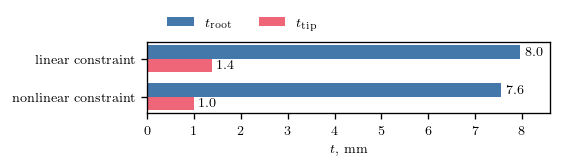

In [24]:
figure_name = "LRAThicknesses"
plot_thickness_bar_chart(sol_105_opt_histories, sol_106_opt_histories, figure_name, feasible_design_index)

Comparison of nonlinear structural stability response of initial structure vs linearly optimized structure vs nonlinearly optimized structure.

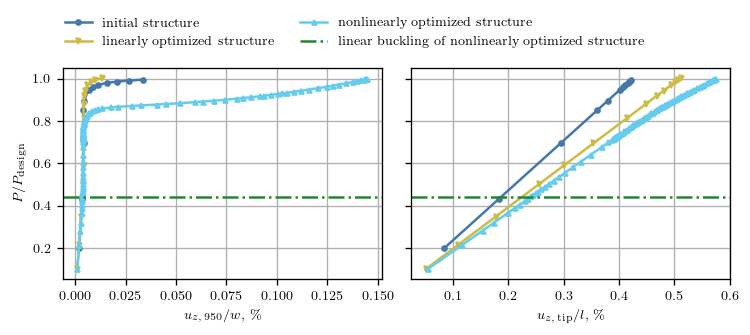

In [25]:
# Initialize dictionary with names of input files
input_name_dict = {"initial structure": "sol_106_lra_linear_opt_start",
                   "linearly optimized structure": "sol_106_lra_linear_opt",
                   "nonlinearly optimized structure": "sol_106_lra_nonlinear_opt"}

# Plot load-displacement diagrams
fig, axes, stable_lines, eigenvalues_dict, sol_106_op2_dict, nondimensional_applied_loads_dict = plot_load_displacement_diagram(input_name_dict)

sol_105_input_name = "sol_105_lra_nonlinear_opt"
sol_105_op2 = read_op2(os.path.join(ANALYSIS_DIRECTORY_PATH, sol_105_input_name + '.op2'), load_geometry=True, debug=None)
buckling_load_factor = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
axes[0].axhline(y=buckling_load_factor, color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling
axes[1].axhline(y=buckling_load_factor, color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling
glass_ceiling_line = Line2D([0], [0], linestyle='-.', color=GLASS_CEILING_COLOR, label="linear buckling of nonlinearly optimized structure")

# Set plot appearance for the first subplot
axes[0].set_xlabel(f"$u_{{z,\,{max_displacement_node_id:d}}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[1].grid(visible=True)

# Save figure
plt.tight_layout()  # ensures proper spacing between subplots
axes[0].legend(handles=stable_lines + [glass_ceiling_line], loc="upper left",
               ncols=2, bbox_to_anchor=(-.03, 1.3), frameon=False)  # add legend after tight_layout
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "LRALoadDisplacementDiagram.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Compare deformation at design load of linearly vs nonlinearly optimized structure.

Deformation of linearly optimized structure


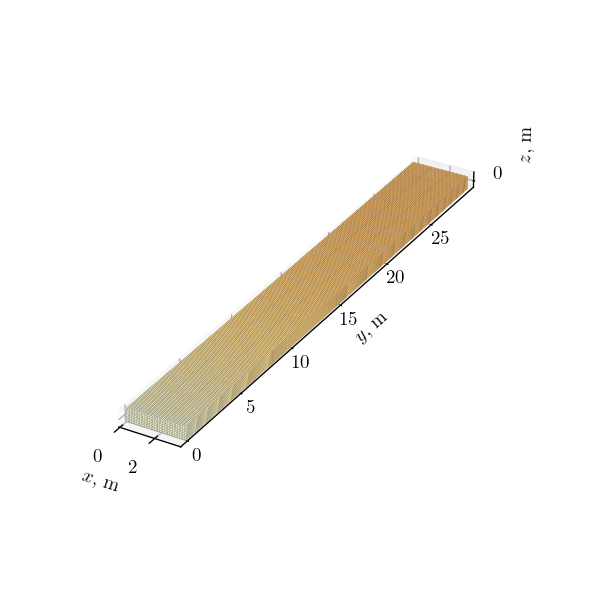

Deformation of nonlinearly optimized structure


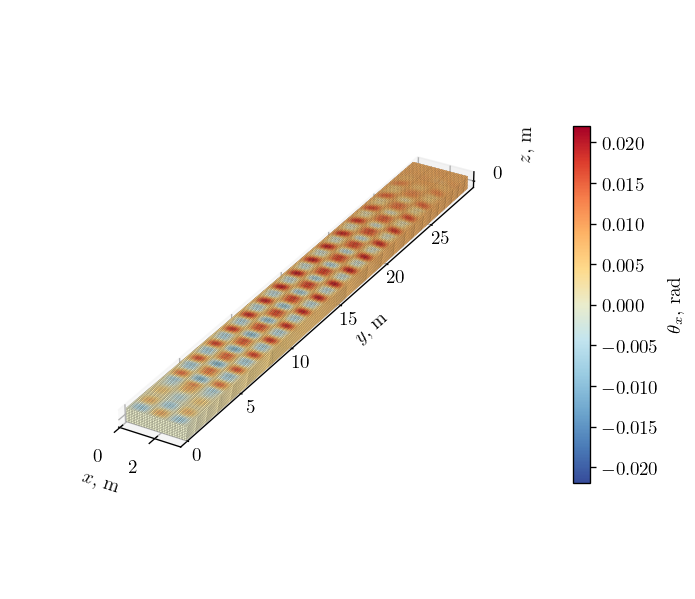

In [26]:
label = "lra"
plot_deformation_comparison(nondimensional_applied_loads_dict, sol_106_op2_dict, label)

### Comparative discussion <a name="comparative"></a>

Plot bar chart of final masses.

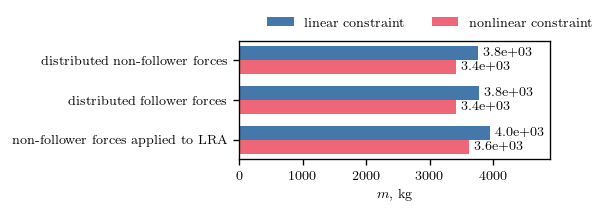

Percentage differences of final masses w.r.t. initial mass:
- distributed non-follower forces: -47.6%
- distributed follower forces: -47.5%
- non-follower forces applied to LRA: -44.4%



In [27]:
# Set up data for the bar chart
optimizations = ("distributed non-follower forces", "distributed follower forces", "non-follower forces applied to LRA")

# Plot bar chart with final thicknesses
y_pos = np.arange(len(optimizations))  # the label locations
height = 0.35  # the height of the bars
multiplier = .5  # multiplier to separate bars
fig, ax = plt.subplots(figsize=(FIG_WIDTH_INCHES*1.5, FIG_HEIGHT_INCHES/1.5))  # create figure and axis
for attribute, values in final_masses.items():  # iterate over attributes and values
    offset = height * multiplier  # offset to separate bars
    rects = ax.barh(y_pos + offset, values, height, label=attribute)  # plot bars
    ax.bar_label(rects, padding=3, fmt="{:,.1e}")  # add labels to bars
    multiplier += 1  # increase multiplier to separate bars

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("$m$, kg")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_yticks(y_pos + height, optimizations)
ax.set_xlim(right=4.9e3)  # set limits of x-axis

# Save figure
plt.tight_layout()  # ensures proper spacing between subplots
ax.legend(bbox_to_anchor=(0.05, 1.), ncols=2, frameon=False)  # add legend after tight layout
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "FinalMassesBarChart.svg"), format='svg', bbox_inches='tight', pad_inches=0)

# Calculate percentage differences w.r.t. initial mass
key = "nonlinear constraint"
print(f"""Percentage differences of final masses w.r.t. initial mass:
- distributed non-follower forces: {100*(final_masses[key][0] - initial_mass)/initial_mass:.1f}%
- distributed follower forces: {100*(final_masses[key][1] - initial_mass)/initial_mass:.1f}%
- non-follower forces applied to LRA: {100*(final_masses[key][2] - initial_mass)/initial_mass:.1f}%
""")

## Appendix <a name="appendix"></a>

***

Plot mesh convergence study.

Prescribed length of shell elements for mesh convergence study [mm]:
[385.    255.537 169.608 112.575  74.72   49.594  32.917  21.848  14.501
   9.625]


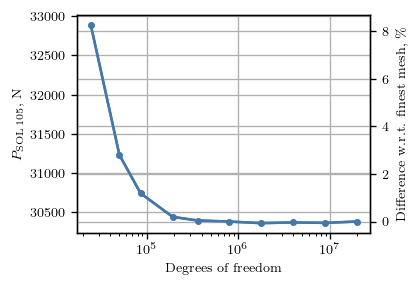

In [28]:
from resources import box_beam_utils

# Define additional geometric parameters
no_stiffeners = 2  # number of stiffeners
h_s = H/10  # height of stiffeners [mm]
stiffeners_x_locations = np.linspace(0, W, no_stiffeners + 2)[1:-1]  # [mm] stiffeners x-coordinates
stiffeners_spacing = W/(no_stiffeners + 1)  # [mm] stiffeners spacing
ribs_spacing = stiffeners_spacing*1.4 # [mm] ribs spacing
no_ribs = round(L/ribs_spacing) + 1  # number of ribs
ribs_y_locations = np.linspace(0, L, no_ribs)  # [mm] ribs y-coordinates

# Define shell elements' lengths to be used for the mesh convergence study and print them to screen
shell_element_lengths = np.geomspace(H/2, h_s/8, 10) # [mm]
np.set_printoptions(precision=3, suppress=True)
print("Prescribed length of shell elements for mesh convergence study [mm]:")
print(shell_element_lengths)

# Initialize arrays with number of elements, number of degrees of freedom and linear buckling loads
dofs = np.empty(np.shape(shell_element_lengths), dtype=int)
linear_buckling_loads = np.empty(np.shape(shell_element_lengths))

# Iterate through the different target element lengths
for count, element_length in enumerate(shell_element_lengths):
    # Generate mesh
    mesh = box_beam_utils.mesh_box_beam_reinforced_with_ribs_and_stiffeners(
        width=W, height=H, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
        stiffeners_height=h_s, element_length=element_length)
    nodes_connectivity_matrix = mesh.faces.reshape(-1, 5)[:, 1:]
    
    # Read op2 file
    input_name = f"sol_105_{len(nodes_connectivity_matrix)}_elements"
    op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2')
    sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
    
    # Find number of degrees of freedom and critical buckling load
    constrained_nodes_ids = next(iter(sol_105_op2.spcs.values()))[0].node_ids
    dofs[count] = (len(sol_105_op2.nodes) - len(constrained_nodes_ids))*6
    linear_buckling_loads[count] = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
    
# Plot buckling loads vs degrees of freedom with a log scale along the x-axis
fig, ax1 = plt.subplots(figsize=(FIG_WIDTH_INCHES, FIG_HEIGHT_INCHES))  # create a figure and set of axes
buckling_load_line = ax1.semilogx(dofs, linear_buckling_loads, 'o-')

# Create a twin set of axes to plot percentage difference vs degrees of freedom
ax2 = ax1.twinx()
percentage_diff = (linear_buckling_loads/linear_buckling_loads[-1]-1)*100
percentage_diff_line = ax2.plot(dofs, percentage_diff, 'o-')

# Set axes labels and grid
ax1.set_xlabel("Degrees of freedom")
ax1.set_ylabel("$P_\mathrm{SOL\,105}$, N")
ax2.set_ylabel("Difference w.r.t. finest mesh, \%")
ax1.grid(True)
ax2.grid(True)

# Show plot and save figure
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "MeshConvergenceStudy.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Plot mesh convergence verification.

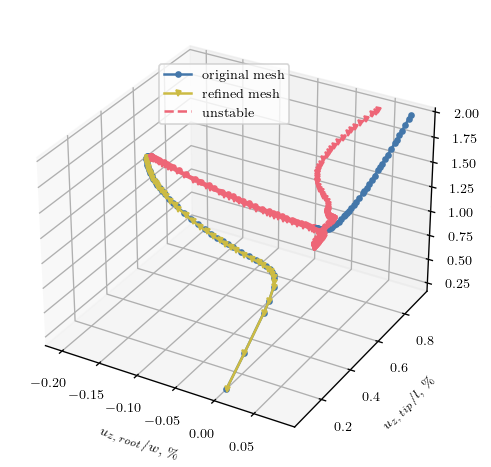

In [29]:
# Define dictionary with names of input files
input_name_dict = {"original mesh": "33120_elements",
                   "refined mesh": "108276_elements"}

# Initialize dictionaries to store ids of nodes where max displacement occurs and tip nodes
root_node_id_dict = {}  # dictionary to store ids of nodes where max displacement occurs
tip_node_id_dict = {}  # dictionary to store ids of tip nodes

# Create 3D plot of equilibrium diagram
fig = plt.figure()  # create a figure
ax_3d = plt.axes(projection="3d")  # create 3D axes
stable_lines = []  # list to store proxy artists for the legend

# Iterate over the different meshes
for count, key in enumerate(input_name_dict):
    # Read op2 file of linear buckling analysis
    op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, f"sol_105_{input_name_dict[key]}.op2")
    sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)

    # Find node where max displacement occurs
    max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
    root_node_id_dict[key] = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[max_displacement_index, 0]  # find id of node with max displacement magnitude
    
    # Find tip node id
    nodes_xyz_array = np.array([node.xyz for node in sol_105_op2.nodes.values()])  # get nodes' coordinates
    tip_node_id_dict[key] = np.argmin(np.linalg.norm(nodes_xyz_array - tip_node_xyz, axis=1)) + 1  # find id of tip node

    # Read op2 file of nonlinear analysis
    op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, f"sol_106_{input_name_dict[key]}.op2")
    sol_106_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
    
    # Read load-displacement history
    _, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_op2, node_ids=[root_node_id_dict[key], tip_node_id_dict[key]])
    
    # Read eigenvalues
    f06_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, f"sol_106_{input_name_dict[key]}.f06")  # path of f06 file
    eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)  # read eigenvalues from f06 file

    # Nondimensionalize loads and displacements
    nondimensional_loads = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/design_load
    nondimensional_displacements = {"root": displacements[root_node_id_dict[key]][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/W,
                                    "tip": displacements[tip_node_id_dict[key]][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/L}

    # Plot load-displacement curve
    plot_utils.plot_3d_load_displacements_stability(axes=ax_3d,
                                                    displacements1=nondimensional_displacements["root"]*100,
                                                    displacements2=nondimensional_displacements["tip"]*100,
                                                    loads=nondimensional_loads,
                                                    eigenvalues=eigenvalues,
                                                    marker=MARKERS[count], color=COLORS[count])
    stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[count], color=COLORS[count], label=key))  # create proxy artist for the legend

# Add proxy artist for unstable lines and create legend
fig.legend(handles=stable_lines + [unstable_line], loc="upper center", bbox_to_anchor=(0.5, 0.8))

# Set axes labels and grid
ax_3d.set_xlabel("$u_{z,\,root}/w$, \%")
ax_3d.set_ylabel("$u_{z,\,tip}/l$, \%")
ax_3d.set_zlabel("$P/P_\mathrm{design}$")
ax_3d.grid(visible=True)

# Show plot and save figure
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "MeshConvergenceVerification.svg"), format='svg', bbox_inches='tight', pad_inches=0)